In [3]:
!pip3 install keras

In [10]:
from project_lib import Project
project = Project(project_id='PID', project_access_token='TOKEN')
pc = project.project_context

In [11]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['figure.figsize']=10,6
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.models import Sequential
import time
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("."))

# Any results you write to the current directory are saved as output.

[]


In [16]:
def get_file_handle(fname):
    # Project data path for the raw data file
    data_path = project.get_file(fname)
    data_path.seek(0)
    return data_path

# Using pandas to read the data 
# Since the `DATE` column consists date-time information, we use Pandas parse_dates keyword for easier data processing
data_path = get_file_handle('rainfall in india 1901-2015.csv')
data = pd.read_csv(data_path, encoding = "ISO-8859-1")
data.dtypes
# Set date index
# data = data.set_index(pd.DatetimeIndex(data['DATE']))
# data.drop(['DATE'], axis=1, inplace=True)
# data.head()

SUBDIVISION     object
YEAR             int64
JAN            float64
FEB            float64
MAR            float64
APR            float64
MAY            float64
JUN            float64
JUL            float64
AUG            float64
SEP            float64
OCT            float64
NOV            float64
DEC            float64
ANNUAL         float64
Jan-Feb        float64
Mar-May        float64
Jun-Sep        float64
Oct-Dec        float64
dtype: object

In [18]:
groups = data.groupby('SUBDIVISION')[['YEAR','JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','NOV','DEC']]
dataset=groups.get_group(('BIHAR'))
dataset.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,NOV,DEC
897,1901,51.8,19.6,11.9,1.1,65.6,66.3,245.9,319.4,155.1,7.3,0.1
898,1902,4.6,0.7,24.3,17.3,66.3,118.2,361.0,225.5,358.7,1.1,0.0
899,1903,5.3,4.7,2.0,4.7,28.2,192.9,115.0,342.6,173.9,0.1,0.0
900,1904,6.3,1.7,3.5,5.3,118.7,191.6,394.4,351.3,84.4,10.6,3.8
901,1905,16.0,30.1,32.6,21.4,77.5,50.5,409.1,495.3,353.9,0.0,0.6


In [19]:
dataset=dataset.melt(['YEAR']).reset_index()
dataset.head()


,index,YEAR,variable,value
0,0,1901,JAN,51.8
1,1,1902,JAN,4.6
2,2,1903,JAN,5.3
3,3,1904,JAN,6.3
4,4,1905,JAN,16.0


In [20]:
df= dataset[['YEAR','variable','value']].reset_index().sort_values(by=['YEAR','index'])
df.head()

,index,YEAR,variable,value
0,0,1901,JAN,51.8
115,115,1901,FEB,19.6
230,230,1901,MAR,11.9
345,345,1901,APR,1.1
460,460,1901,MAY,65.6


In [21]:
df.columns=['INDEX','YEAR','Month','avg_rainfall']

In [22]:
df.head()

,INDEX,YEAR,Month,avg_rainfall
0,0,1901,JAN,51.8
115,115,1901,FEB,19.6
230,230,1901,MAR,11.9
345,345,1901,APR,1.1
460,460,1901,MAY,65.6


In [23]:
d={'JAN':1,'FEB':2,'MAR' :3,'APR':4,'MAY':5,'JUN':6,'JUL':7,'AUG':8,'SEP':9,
   'OCT':10,'NOV':11,'DEC':12}
df['Month']=df['Month'].map(d)
df.head(12)

,INDEX,YEAR,Month,avg_rainfall
0,0,1901,1,51.8
115,115,1901,2,19.6
230,230,1901,3,11.9
345,345,1901,4,1.1
460,460,1901,5,65.6
575,575,1901,6,66.3
690,690,1901,7,245.9
805,805,1901,8,319.4
920,920,1901,9,155.1
1035,1035,1901,11,7.3


In [24]:
df['Date']=pd.to_datetime(df.assign(Day=1).loc[:,['YEAR','Month','Day']])
df.head(12)

,INDEX,YEAR,Month,avg_rainfall,Date
0,0,1901,1,51.8,1901-01-01
115,115,1901,2,19.6,1901-02-01
230,230,1901,3,11.9,1901-03-01
345,345,1901,4,1.1,1901-04-01
460,460,1901,5,65.6,1901-05-01
575,575,1901,6,66.3,1901-06-01
690,690,1901,7,245.9,1901-07-01
805,805,1901,8,319.4,1901-08-01
920,920,1901,9,155.1,1901-09-01
1035,1035,1901,11,7.3,1901-11-01


In [25]:
cols=['avg_rainfall']
dataset=df[cols]
dataset.head()

,avg_rainfall
0,51.8
115,19.6
230,11.9
345,1.1
460,65.6


In [26]:
series=dataset
series.head()

,avg_rainfall
0,51.8
115,19.6
230,11.9
345,1.1
460,65.6


In [27]:
series.shape

(1265, 1)

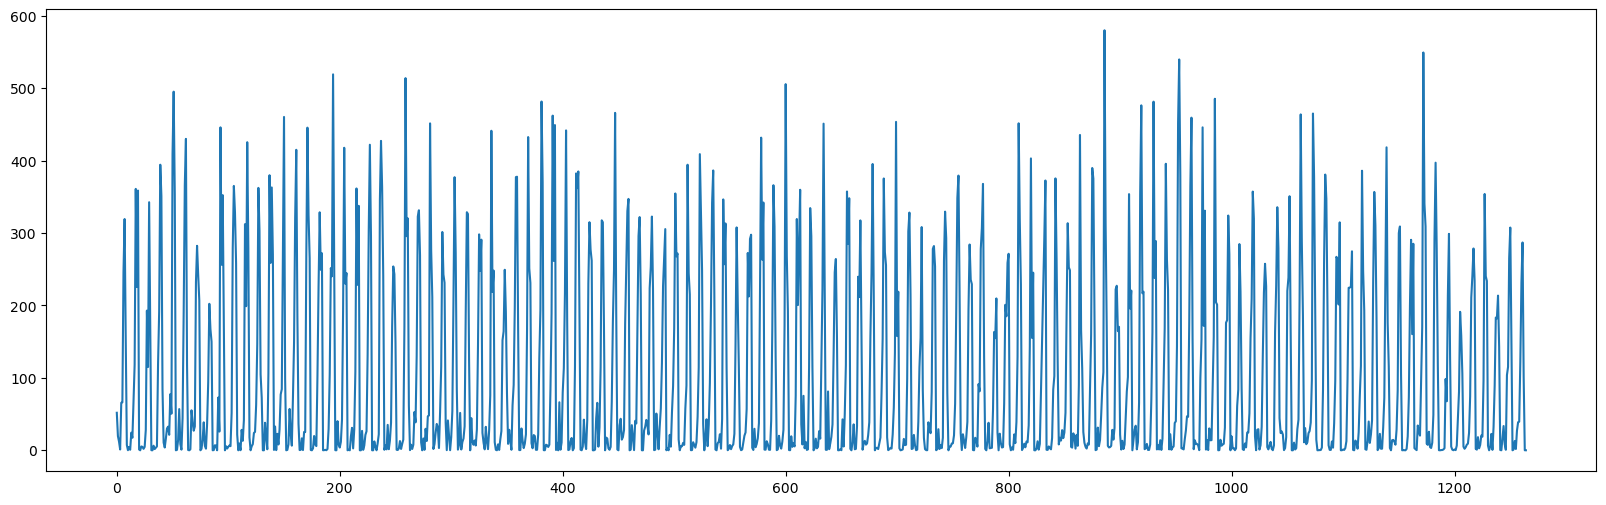

In [28]:
pyplot.figure(figsize=(20,6))
pyplot.plot(series.values)
pyplot.show()

In [29]:
# Get the raw data values from the pandas data frame.
data_raw = series.values.astype("float32")

# We apply the MinMax scaler from sklearn
# to normalize data in the (0, 1) interval.
scaler = MinMaxScaler(feature_range = (0, 1))
f_dataset = scaler.fit_transform(data_raw)

# Print a few values.
f_dataset[0:5]

array([[0.08929496],
       [0.03378728],
       [0.02051371],
       [0.00189622],
       [0.11308396]], dtype=float32)

In [30]:
# Using 60% of data for training, 40% for validation.
TRAIN_SIZE = 0.80

train_size = int(len(f_dataset) * TRAIN_SIZE)
test_size = len(f_dataset) - train_size
train, test = f_dataset[0:train_size, :], f_dataset[train_size:len(f_dataset), :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

Number of entries (training set, test set): (1012, 253)


In [31]:
# FIXME: This helper function should be rewritten using numpy's shift function. See below.
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [32]:
# Create test and training sets for one-step-ahead regression.
window_size = 1
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

Original training data shape:
(1010, 1)
New training data shape:
(1010, 1, 1)


In [36]:
def fit_model(train_X, train_Y, window_size = 1):
    model = Sequential()
    
    model.add(LSTM(2000,activation = 'tanh', recurrent_activation = 'hard_sigmoid', input_shape = (1, window_size)))
    model.add(Dropout(0.2))
    model.add(Dense(500))
    model.add(Dropout(0.4))
    model.add(Dense(500))
    model.add(Dropout(0.4))
    model.add(Dense(400))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'linear'))
    model.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
    model.fit(train_X, 
              train_Y, 
              epochs = 10, 
              batch_size = 64, 
              )
    
    return(model)

In [37]:
# # Fit the first model.
model1 = fit_model(train_X, train_Y, window_size)

Epoch 1/10
16/16 [==============================] - 5s 162ms/step - loss: 0.0454
Epoch 2/10
16/16 [==============================] - 2s 155ms/step - loss: 0.0362
Epoch 3/10
16/16 [==============================] - 3s 164ms/step - loss: 0.0377
Epoch 4/10
16/16 [==============================] - 3s 166ms/step - loss: 0.0374
Epoch 5/10
16/16 [==============================] - 3s 168ms/step - loss: 0.0358
Epoch 6/10
16/16 [==============================] - 3s 165ms/step - loss: 0.0372
Epoch 7/10
16/16 [==============================] - 3s 168ms/step - loss: 0.0374
Epoch 8/10
16/16 [==============================] - 3s 167ms/step - loss: 0.0379
Epoch 9/10
16/16 [==============================] - 3s 172ms/step - loss: 0.0380
Epoch 10/10
16/16 [==============================] - 3s 163ms/step - loss: 0.0369


In [38]:
import math
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(model1, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model1, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

8/8 [==============================] - 0s 12ms/step
Training data score: 108.68 RMSE
Test data score: 96.91 RMSE


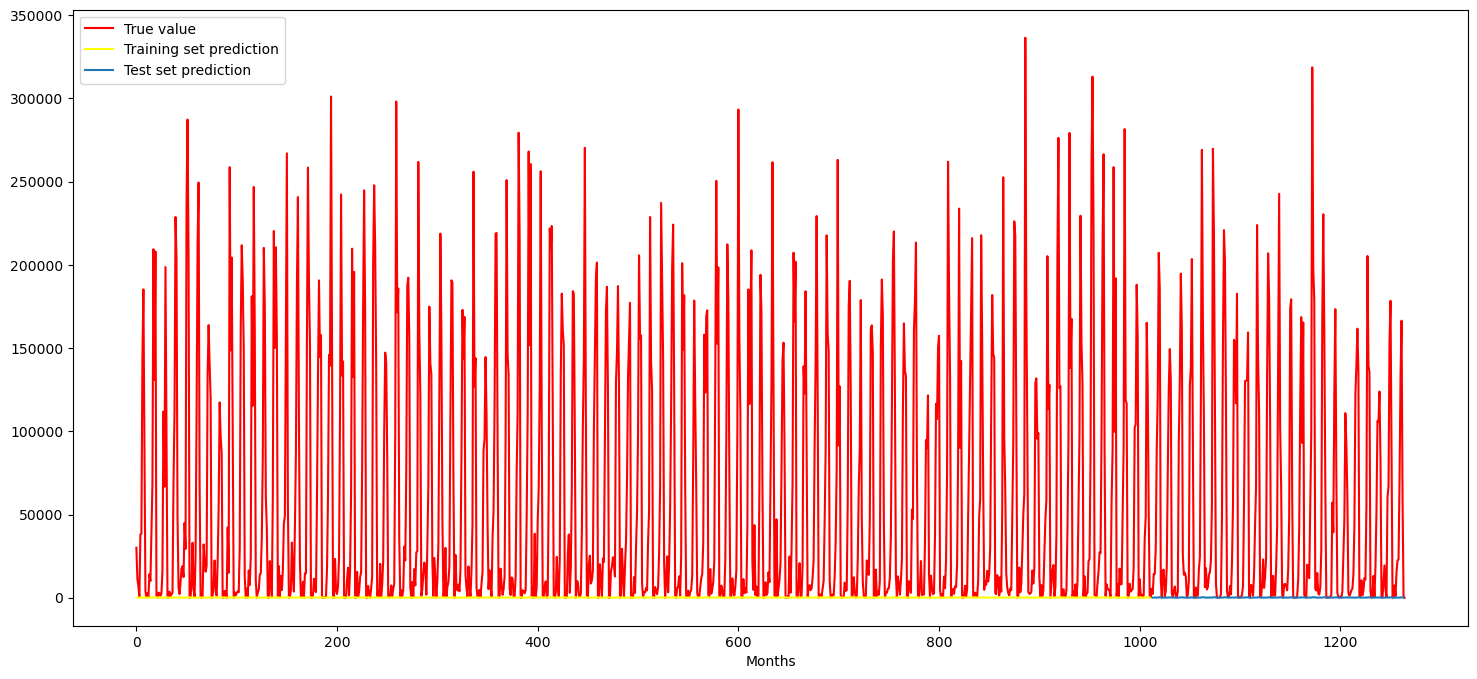

In [39]:
# Start with training predictions.
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (18, 8))
plt.plot(scaler.inverse_transform(dataset), label = "True value",color='red')
plt.plot(train_predict_plot, label = "Training set prediction",color='yellow')
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Months")


plt.legend()
plt.show()

In [40]:
test_predict

array([[ 68.10796 ],
       [ 64.90553 ],
       [ 77.05217 ],
       [ 77.05217 ],
       [ 92.769714],
       [153.5765  ],
       [185.11989 ],
       [270.17615 ],
       [248.91098 ],
       [ 73.97382 ],
       [ 62.59141 ],
       [ 79.30053 ],
       [ 79.77375 ],
       [ 63.12555 ],
       [ 66.68491 ],
       [ 81.902664],
       [139.62817 ],
       [190.09705 ],
       [213.12198 ],
       [195.18465 ],
       [ 65.14283 ],
       [ 63.244225],
       [ 66.566315],
       [ 69.41209 ],
       [ 63.71894 ],
       [ 62.59141 ],
       [ 66.507   ],
       [158.29478 ],
       [195.76248 ],
       [257.87338 ],
       [225.48341 ],
       [ 88.81541 ],
       [ 76.637886],
       [ 77.93981 ],
       [ 75.39484 ],
       [ 62.65077 ],
       [ 64.31228 ],
       [ 73.3224  ],
       [191.4851  ],
       [202.11368 ],
       [266.53424 ],
       [158.06189 ],
       [ 62.53207 ],
       [ 62.53207 ],
       [ 68.76007 ],
       [ 63.18489 ],
       [ 64.252945],
       [ 79.8

In [41]:
train_predict

array([[ 93.18266],
       [ 74.15148],
       [ 69.58989],
       ...,
       [228.75526],
       [190.96463],
       [113.25846]], dtype=float32)